# Homework  2
## Large Scale Data Analysis / Aalto University, Spring 2023

This homework set consists of <b>3 questions</b>. You will implement the Bagging algorithm, Random Forest and AdaBoost.M1 by yourself. 

## Student Name: Nguyen Xuan Binh
## Student ID: 887799

## Import packages
Note: you do not need any other packages, so if you import something else, please specify why you need those packages

In [28]:
import numpy as np
import time
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import matplotlib as mpl 
import pandas as pd 
from sklearn.metrics import accuracy_score
mpl.style.use('default')
# I need this "time" library to stop the code for debugging purposes. Nothing related to this assignment
import time
# This library is for displaying images
from IPython.display import Image, display

### Create the data

In [98]:
from scipy.stats import chi2
def generate_data(n, p):
    x = np.random.normal(size=(n, p))
    sdX = np.sum(x ** 2, axis=1)
    c = chi2.ppf(q=0.5, df=p)
    y = np.ones(n)
    y[sdX <= c] = -1
    return x, y

N = 2000
Nt = 10000
p = 10
np.random.seed(0)
X, y = generate_data(N, p)
Xt, yt = generate_data(Nt, p)

***
## Question 1
In this problem you will implement the bagging algorithm in the 
binary classification problem and use it to redo the Figure 3.3.

You can compare your results with scikit-learn:

In [5]:
B=200 # number of bootstrapped trees

In [6]:
from sklearn.ensemble import BaggingClassifier
%time sk_Bag = BaggingClassifier(n_estimators=B,random_state=123).fit(X,y)
errBag = 1-accuracy_score(yt,sk_Bag.predict(Xt))
print("Sklearn Bagging error rate  : {:5.2f}%".format(100*errBag))

Wall time: 3.34 s
Sklearn Bagging error rate  : 14.12%


### Helper functions

In [92]:
def randomMaximumIndices1D(array):
    return np.random.choice(np.argwhere(array == np.amax(array)).flatten())

def randomMaximumLabelDict(dictionary):
    max_value = max(dictionary.values())
    keys = np.array([k for k, v in dictionary.items() if v == max_value])
    return np.random.choice(keys)

## 1 (a) 
The bagging algorithm for classification is described in Algorithm 3.1 of lecture notes. Write this function yourself by writing a function named <code>MyBagging</code> having outputs a list  <code>Trees</code> that contains the <code>B</code> bagged decision trees and an array or list  <code>err</code> that contains the <code>B</code> out-of-bag (OOB) training errors when a new tree is added. The <code>majorityvoting</code> is option flag for fitting either using majority voting or largest mean probability prediction.   

_Note:_ 
 You shoud use <code>DecisionTreeClassifier</code> to compute the classification decision tree (with default options). You are not allowed to use <code>BaggingClassifier</code> in the implemention of <code>MyBagging</code>

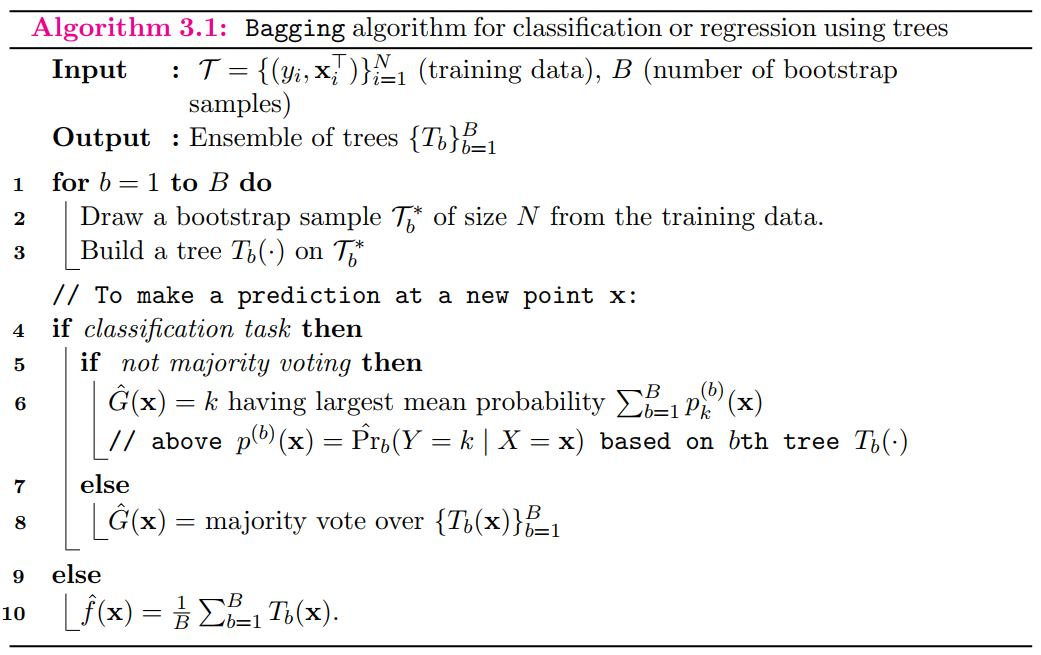

In [21]:
Image("images/bagging.png")

In [104]:
def MyBagging(X, y, B, majorityvoting=False):
    """
      MyBagging
      
      params:    
        X,y             (input,output) data. Outputs y need to have elements between -1 and 1. 
        B               positive integer, stating the number of boosted trees
        majorityvoting  flag (False/True) to handle predictions (majority vote or mean probability)
    """    
    Trees = []
    Err = []
    boot_indices = []
    oob_indices = []
    N = y.size
    for b in range(0, B):
        bootstrapped_index = np.random.choice(X.shape[0], size=N, replace=True)
        oob_index = np.setdiff1d(np.arange(X.shape[0]), bootstrapped_index)
        boot_indices.append(bootstrapped_index)
        oob_indices.append(oob_index)
        

        X_boot = X[bootstrapped_index, :]
        y_boot = y[bootstrapped_index]
        tree = DecisionTreeClassifier()
        tree.fit(X_boot, y_boot)
        Trees.append(tree)

    labels = Trees[0].classes_ 
    num_labels = len(labels)

    mean_probability = np.zeros((N, num_labels))
    majority_votes =  [{label: 0 for label in labels} for _ in range(N)]
    
    for b in range(0, B):
        currentTree = Trees[b]
        if not majorityvoting:
            probability = currentTree.predict_proba(X) # Probability is of dimension (len_oob, num_labels) just like y_pred_prob_sum
            for i in boot_indices[b]:
                probability[i] = np.zeros(mean_probability.shape[1])
            mean_probability += probability
            # This line already takes care of the random label assignment when the feature has all 0s posterior across all labels
            # Find index of the label with maximum mean probability for each datapoint
            y_pred_indices = np.argmax(mean_probability, axis=1)
            # Truly random, but very slow
            #y_pred_indices = np.apply_along_axis(randomMaximumIndices1D, 1, mean_probability) 
            y_pred = labels[y_pred_indices]
            err = 1 - accuracy_score(y,y_pred)
            Err.append(err)
        else:
            votes = currentTree.predict(X) # votes is of dimension (len_oob, )
            for i in oob_indices[b]:                
                majority_votes[i][votes[i]] += 1
            # This line already takes care of the random label assignment when the feature has all 0s posterior across all labels
            # Find label (key in dict) with maximum votes (value) for each datapoint
            y_pred = [max(d, key=d.get) for d in majority_votes]
            # Truly random, but very slow
            # y_pred = list(map(randomMaximumLabelDict, majority_votes)) 
            err = 1 - accuracy_score(y,y_pred)
            Err.append(err)
    return Trees, Err

# Trees, trainingErrors = MyBagging(X, y, B, majorityvoting=True)

## 1 (b)
Write a function <code>PredictBagging</code> that computes the predicted class labels <code>yhat</code> for input data <code>X</code> for each bagged tree as well as the error rate <code>Err</code> at each iteration, i.e., when a new tree is added, given the true labels <code>y</code>. The input  <code>Trees</code> is the output from <code>MyBagging</code>. For prediction, the flag <code>majorityvoting</code> is used to return prediction either by using majority voting or largest mean probability prediction of trees. In the case of majority voting, handle the case of ties by random guessing. 

In [100]:
def PredictBagging(Trees, X, y, majorityvoting=False):
    """
      PredictBagging
      
      params:
        Trees           A list of Bagged trees
        X,y             (input,output) data. Outputs y need to have elements between -1 and 1. 
        majorityvoting  flag (False/True) to handle predictions (majority vote or mean probability)
    """    

    # X, y this time will be the testing data instead of the training data in MyBagging
    yhat = []
    Err = []
    N = y.size
    
    labels = Trees[0].classes_ 
    num_labels = len(labels)
    
    mean_probability = np.zeros((N, num_labels))
    majority_votes =  [{label: 0 for label in labels} for _ in range(N)]
    
    for b in range(0, B):
        currentTree = Trees[b]
        if not majorityvoting:
            probability = currentTree.predict_proba(X) # Probability is of dimension (len_oob, num_labels) just like y_pred_prob_su
            mean_probability += probability
            # This line already takes care of the random label assignment when the feature has all 0s posterior across all labels
            # Find index of the label with maximum mean probability for each datapoint
            y_pred_indices = np.argmax(mean_probability, axis=1)
            # Truly random, but very slow
            #y_pred_indices = np.apply_along_axis(randomMaximumIndices1D, 1, mean_probability) 
            y_pred = labels[y_pred_indices]
            yhat.append(y_pred)
            err = 1 - accuracy_score(y,y_pred)
            Err.append(err)
        else:
            votes = currentTree.predict(X) # votes is of dimension (len_oob, )
            for i in range(0, N):                
                majority_votes[i][votes[i]] += 1
            # This line already takes care of the random label assignment when the feature has all 0s posterior across all labels
            # Find label (key in dict) with maximum votes (value) for each datapoint
            y_pred = [max(d, key=d.get) for d in majority_votes]
            yhat.append(y_pred)
            # Truly random, but very slow
            # y_pred = list(map(randomMaximumLabelDict, majority_votes)) 
            err = 1 - accuracy_score(y,y_pred)
            Err.append(err)
    return yhat, Err

# yhat, testingErrors = PredictBagging(Trees, X, y, majorityvoting=False)

## 1 (c)
Use the functions you made in part 1(a) and 1(b) to redo the Figure 3.3a in the lecture notes. Use <code>np.random.seed(123)</code> before running the <code>MyBagging</code> for reproducible results. 
This will set the random seed before running the method. This is because of randomness in bootstrap samples. 

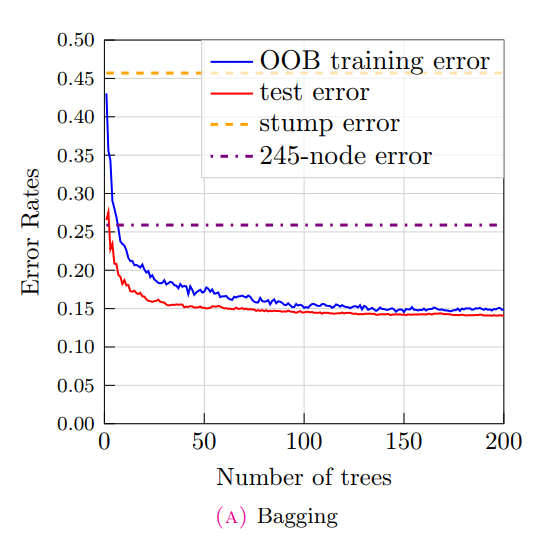

In [22]:
#### This is Figure 3.3a referenced figure
Image("images/bagging_errors.png")

In [56]:
np.random.seed(123)

stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X, y)
ypred_test = stump.predict(Xt)
stump_error = 1 - accuracy_score(yt, ypred_test)

# Number of nodes in the tree
n_nodes = stump.tree_.node_count
print("Number of nodes in the stump:", n_nodes)

tree_manynodes = DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=2)
tree_manynodes.fit(X, y)
ypred_test = tree_manynodes.predict(Xt)
tree_manynodes_error = 1 - accuracy_score(yt, ypred_test)

# Number of nodes in the tree
n_nodes = tree_manynodes.tree_.node_count
print("Number of nodes in the bigger tree:", n_nodes)

Number of nodes in the stump: 3
Number of nodes in the bigger tree: 243


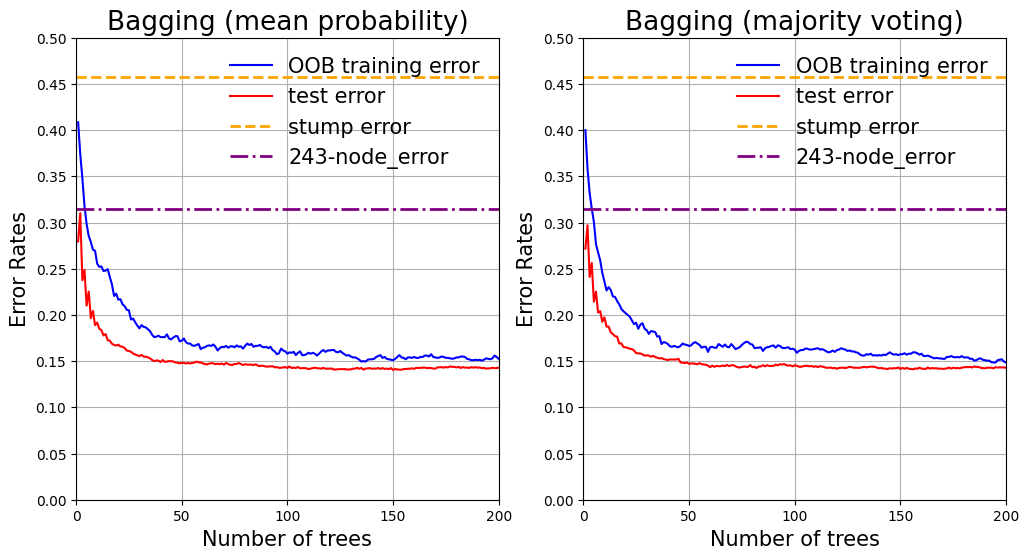

In [105]:
# your code here
size = 15
majorityvoting = [False, True]
flag = ["mean probability", "majority voting"]


numberOfTrees = range(1,B+1)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(2):
    Trees, trainingErrors = MyBagging(X, y, B, majorityvoting=majorityvoting[i])
    yhat, testingErrors = PredictBagging(Trees, Xt, yt, majorityvoting=majorityvoting[i])

    axs[i].set_title(f"Bagging ({flag[i]})", size=size + 4)
    axs[i].plot(numberOfTrees, trainingErrors, label = "OOB training error", color="blue")
    axs[i].plot(numberOfTrees, testingErrors, label = "test error", color="red")
    axs[i].axhline(y=stump_error, label = "stump error", color='orange', lw=2, linestyle="--")
    axs[i].axhline(y=tree_manynodes_error, label = f"{n_nodes}-node_error", color='purple', lw=2, linestyle="-.")
    axs[i].set_xticks([0, 50, 100, 150, 200],fontsize=size)    
    axs[i].set_yticks(np.linspace(0.00, 0.50, num=11),fontsize=size)  
    axs[i].set_ylim([0, 0.5])
    axs[i].set_xlim([0, 200])
    axs[i].set_xlabel("Number of trees", size=size)
    axs[i].set_ylabel("Error Rates", size=size)
    axs[i].legend(loc=1, frameon=False, fontsize=size)
    axs[i].grid()

***
## Question 2
In this problem you will implement the random forest algorithm in the  binary classification problem and use it to redo the Figure 3.3b in the lecture notes.

_Hint_: Again you shoud use <code>DecisionTreeClassifier</code> to compute the classification decision tree. You can use the <code>PredictBagging</code> function you implemented in problem 1b to compute the predicted class labels for  an input data <code>X</code>. 

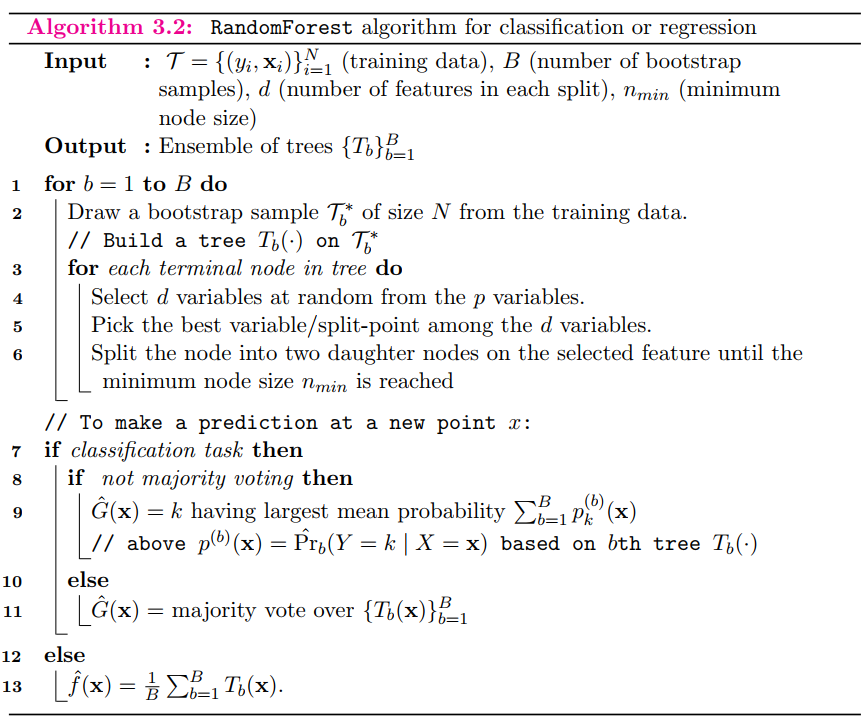

In [23]:
Image("images/randomforest.png")

In [7]:
B = 200
d = 2
nmin = 3
RANDOM_STATE=123

You can compare with the scikit-learn:

In [8]:
from sklearn.ensemble import RandomForestClassifier
%time sk_RF = RandomForestClassifier(n_estimators=B,max_features=d,min_samples_leaf=nmin,random_state=RANDOM_STATE).fit(X,y)
errRF_skl = 1-accuracy_score(yt,sk_RF.predict(Xt))
print("Sklearn Random Forest error rate  : {:5.2f}%".format(100*errRF_skl))

Wall time: 769 ms
Sklearn Random Forest error rate  : 12.77%


<b>Note</b>: scikit-learn implementation of RandomForest combines classifiers by averaging their probabilistic prediction (not majority voting!)

###  2 (a)
Implement the random forest algorithm for classification described in algorithm 3.2 by yourself by writing a function named <code>MyRandomForest</code>. The outputs of this function  are an object  <code>Trees</code> which contains the _B_ decision trees classifiers and a  vector or list <code>err</code> that contains the _B_ out-of-bag (OOB) training error when a new tree is added.

In [10]:
def MyRandomForest(X, y, B, d, nmin,majorityvoting=False):
    """
      MyRandomForest function
      
      params:
        X,y            training data 
        B              the number of learners
        d              number of randmized features in each split
        nmin           minimum node size
        majorityvoting  flag (False/True) to handle predictions (majority vote or mean probability)

    """    
    # your code here
    Trees = []
    Err = []
    boot_indices = []
    oob_indices = []
    N = y.size
    for b in range(0, B):
        bootstrapped_index = np.random.choice(X.shape[0], size=N, replace=True)
        oob_index = np.setdiff1d(np.arange(X.shape[0]), bootstrapped_index)
        boot_indices.append(bootstrapped_index)
        oob_indices.append(oob_index)
        

        X_boot = X[bootstrapped_index, :]
        y_boot = y[bootstrapped_index]
        tree = DecisionTreeClassifier(max_features=d,min_samples_leaf=nmin)
        tree.fit(X_boot, y_boot)
        Trees.append(tree)

    labels = Trees[0].classes_ 
    num_labels = len(labels)

    mean_probability = np.zeros((N, num_labels))
    majority_votes =  [{label: 0 for label in labels} for _ in range(N)]
    
    for b in range(0, B):
        currentTree = Trees[b]
        if not majorityvoting:
            probability = currentTree.predict_proba(X) # Probability is of dimension (len_oob, num_labels) just like y_pred_prob_sum
            for i in boot_indices[b]:
                probability[i] = np.zeros(mean_probability.shape[1])
            mean_probability += probability
            # This line already takes care of the random label assignment when the feature has all 0s posterior across all labels
            # Find index of the label with maximum mean probability for each datapoint
            y_pred_indices = np.argmax(mean_probability, axis=1)
            # Truly random, but very slow
            #y_pred_indices = np.apply_along_axis(randomMaximumIndices1D, 1, mean_probability) 
            y_pred = labels[y_pred_indices]
            err = 1 - accuracy_score(y,y_pred)
            Err.append(err)
        else:
            votes = currentTree.predict(X) # votes is of dimension (len_oob, )
            for i in oob_indices[b]:                
                majority_votes[i][votes[i]] += 1
            # This line already takes care of the random label assignment when the feature has all 0s posterior across all labels
            # Find label (key in dict) with maximum votes (value) for each datapoint
            y_pred = [max(d, key=d.get) for d in majority_votes]
            # Truly random, but very slow
            # y_pred = list(map(randomMaximumLabelDict, majority_votes)) 
            err = 1 - accuracy_score(y,y_pred)
            Err.append(err)
    return Trees, Err

# Trees, trainingErrors = MyRandomForest(X, y, B, majorityvoting=True)

## 2 (b)
Write a function <code>PredictRandomForest</code> that computes the predicted class labels <code>yhat</code> for input data <code>X</code> for each tree as well as the error rate <code>Err</code> at each iteration, i.e., when a new tree is added, given the true labels <code>y</code>. The input  <code>Trees</code> is the output from <code>MyRandomFOrest</code>. For prediction, the flag <code>majorityvoting</code> is used to return prediction either by using majority voting or largest mean probability prediction of trees. In the case of majority voting, handle the case of ties by random guessing. 

In [11]:
def PredictRandomForest(Trees, X, y, d, nmin, majorityvoting=False):
    """
      PredictRandomForest
      
      params:
        Trees          A list of trees
        X,y             (input,output) data. Outputs y need to have elements between -1 and 1. 
        d              number of randmized features in each split
        nmin           minimum node size
        majorityvoting  flag (False/True) to handle predictions (majority vote or mean probability)

    """    

    # X, y this time will be the testing data instead of the training data in MyRandomForest
    yhat = []
    Err = []
    N = y.size
    
    labels = Trees[0].classes_ 
    num_labels = len(labels)
    
    mean_probability = np.zeros((N, num_labels))
    majority_votes =  [{label: 0 for label in labels} for _ in range(N)]
    
    for b in range(0, B):
        currentTree = Trees[b]
        if not majorityvoting:
            probability = currentTree.predict_proba(X) # Probability is of dimension (len_oob, num_labels) just like y_pred_prob_su
            mean_probability += probability
            # This line already takes care of the random label assignment when the feature has all 0s posterior across all labels
            # Find index of the label with maximum mean probability for each datapoint
            y_pred_indices = np.argmax(mean_probability, axis=1)
            # Truly random, but very slow
            #y_pred_indices = np.apply_along_axis(randomMaximumIndices1D, 1, mean_probability) 
            y_pred = labels[y_pred_indices]
            yhat.append(y_pred)
            err = 1 - accuracy_score(y,y_pred)
            Err.append(err)
        else:
            votes = currentTree.predict(X) # votes is of dimension (len_oob, )
            for i in range(0, N):                
                majority_votes[i][votes[i]] += 1
            # This line already takes care of the random label assignment when the feature has all 0s posterior across all labels
            # Find label (key in dict) with maximum votes (value) for each datapoint
            y_pred = [max(d, key=d.get) for d in majority_votes]
            yhat.append(y_pred)
            # Truly random, but very slow
            # y_pred = list(map(randomMaximumLabelDict, majority_votes)) 
            err = 1 - accuracy_score(y,y_pred)
            Err.append(err)
    return yhat, Err

# yhat, testingErrors = PredictBagging(Trees, X, y, majorityvoting=False)

### 2 (c)
Use the functions you have made to redo the Figure 3.3b. Use the following parameter values: _d=2_ and _nmin=3_,  _B=200_. 

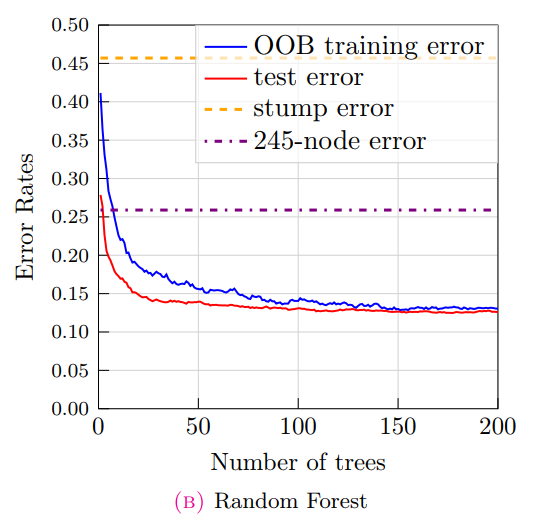

In [24]:
#### This is Figure 3.3b referenced figure
Image("images/randomforest_errors.png")

In [15]:
np.random.seed(123)

stump = DecisionTreeClassifier(min_samples_leaf=2)
stump.fit(X, y)
ypred_test = stump.predict(Xt)
stump_error = 1 - accuracy_score(yt, ypred_test)

# Number of nodes in the tree
n_nodes = stump.tree_.node_count
print("Number of nodes in the stump:", n_nodes)

tree_manynodes = DecisionTreeClassifier(min_samples_leaf=245)
tree_manynodes.fit(X, y)
ypred_test = tree_manynodes.predict(Xt)
tree_manynodes_error = 1 - accuracy_score(yt, ypred_test)

# Number of nodes in the tree
n_nodes = tree_manynodes.tree_.node_count
print("Number of nodes in the bigger tree:", n_nodes)

Number of nodes in the stump: 481
Number of nodes in the bigger tree: 13


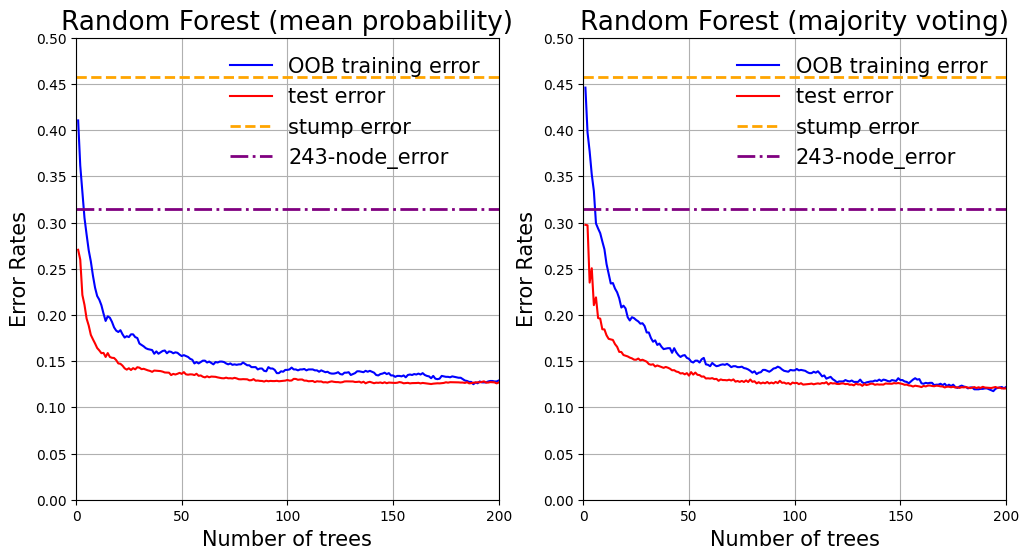

In [14]:
# your code here
size = 15
majorityvoting = [False, True]
flag = ["mean probability", "majority voting"]


numberOfTrees = range(1,B+1)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(2):
    Trees, trainingErrors = MyRandomForest(X, y, B,  d, nmin, majorityvoting=majorityvoting[i])
    yhat, testingErrors = PredictRandomForest(Trees, Xt, yt,  d, nmin, majorityvoting=majorityvoting[i])

    axs[i].set_title(f"Random Forest ({flag[i]})", size=size + 4)
    axs[i].plot(numberOfTrees, trainingErrors, label = "OOB training error", color="blue")
    axs[i].plot(numberOfTrees, testingErrors, label = "test error", color="red")
    axs[i].axhline(y=stump_error, label = "stump error", color='orange', lw=2, linestyle="--")
    axs[i].axhline(y=tree_manynodes_error, label = f"{n_nodes}-node_error", color='purple', lw=2, linestyle="-.")
    axs[i].set_xticks([0, 50, 100, 150, 200],fontsize=size)    
    axs[i].set_yticks(np.linspace(0.00, 0.50, num=11),fontsize=size)  
    axs[i].set_ylim([0, 0.5])
    axs[i].set_xlim([0, 200])
    axs[i].set_xlabel("Number of trees", size=size)
    axs[i].set_ylabel("Error Rates", size=size)
    axs[i].legend(loc=1, frameon=False, fontsize=size)
    axs[i].grid()

***
# Question 3
In this problem you will implement the Adaboost.M1 algorithm and use it  to redo the Figure 4.1.  
_Note_: Again you should use <code>DecisionTreeClassifier</code> to compute the stumps. 

You can compare your algorithm's perforformance to Sklearn. Note that your function should produce the exact same result.

In [14]:
from sklearn.ensemble import AdaBoostClassifier
%time sk_AdaM1 = AdaBoostClassifier(n_estimators=600,algorithm='SAMME').fit(X,y)
%time sk_AdaR = AdaBoostClassifier(n_estimators=600,algorithm='SAMME.R').fit(X,y)
errAdaM1 = 1-accuracy_score(yt,sk_AdaM1.predict(Xt))
errAdaR = 1-accuracy_score(yt,sk_AdaR.predict(Xt))
print("Sklearn AdaBoost.M1 error rate  : {:5.2f}".format(100*errAdaM1))
print("Sklearn AdaBoost.R  error rate  : {:5.2f}".format(100*errAdaR))

CPU times: user 1.48 s, sys: 7.53 ms, total: 1.48 s
Wall time: 1.48 s
CPU times: user 1.6 s, sys: 8.3 ms, total: 1.6 s
Wall time: 1.61 s
Sklearn AdaBoost.M1 error rate  : 10.25
Sklearn AdaBoost.R  error rate  :  5.63


##  (a)
Implement the Adaboost.M1 algorithm described in Algorithm 4.1 using stumps (classification decision trees with two terminal nodes) as the base learner. Write a function <code>MyAdaBoostM1</code>, whose outputs are  a list <code>G</code> that contains the <code>M</code> trees and a list or array <code>alpha</code> that contains weights of each boosting iteration. The input <code>node</code> is the number of leaves you wish to use in your base learner. Default is <code>node=2</code>, so using stumps. 

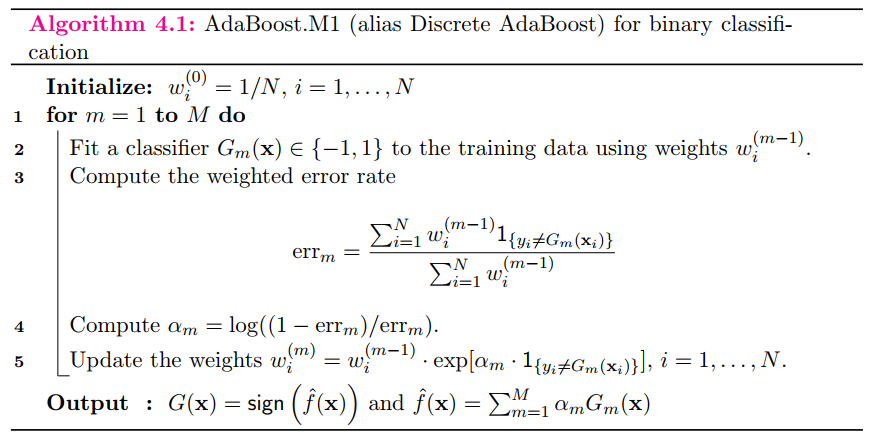

In [25]:
Image("images/adaboostm1.png")

In [72]:
### Helper functions for AdaBoost

def calculate_alpha(weighted_error_rate):
    alpha = np.log((1-weighted_error_rate)/weighted_error_rate)
    return alpha

def calculate_weightedErrorRate(y, ypred, weight):
    error_nominator = np.sum((y != ypred).astype(int) * weight)
    error_denominator = np.sum(weight)
    weighted_error_rate = error_nominator/error_denominator
    return weighted_error_rate

def update_weight(y,ypred,alpha, old_weights):
    difference = (y != ypred).astype(int)
    new_weight = old_weights * np.exp(alpha * difference)
    return new_weight


In [73]:
def MyAdaBoostM1(X, y, M, node=2):
    
    # your code here
    n_samples, n_features = X.shape
    #print(n_samples)
    # Initialize weights to 1/n_samples
    weights = np.ones(n_samples) / n_samples
    #print(weights)
    # Initialize empty list to store base classifiers
    G = []
    # Initialize empty list to store alpha values
    alphas = []
    
    # depth is the 2 logarithm of number of nodes
    depth = int(np.log2(node))
    #print(depth)
    for m in range(1, M + 1):
        # Train a decision tree stump with max depth of node
        Gclf = DecisionTreeClassifier(max_depth=depth)
        Gclf.fit(X, y, sample_weight=weights)
        G.append(Gclf)
        # Make predictions
        ypred = Gclf.predict(X)
        # Calculate error
        weighted_error_rate = calculate_weightedErrorRate(y, ypred, weights)
        # Calculate alpha value
        alpha = calculate_alpha(weighted_error_rate)
        alphas.append(alpha)
        #print(alpha)
        # Update sample weights
        weights = update_weight(y, ypred, alpha, weights)

    return G, alphas

G, alphas = MyAdaBoostM1(X, y, 600, 2)

In [70]:
a = np.array([1,1,-1])
b = np.array([-1,1,1])
weight = [1,2,3]
print((a != b).astype(int) * weight)
print(np.sum(weight))


[1 0 3]
6


## (b)
Write a function <code>PredictAdaBoostM1</code> that computes the predicted data labels and error rate at each boosting iteration for a given input test data. The inputs of the function are <code>G</code> and  <code>alpha</code> which are the outputs from <code>MyAdaBoostM1</code> as well as <code>X</code> and <code>y</code> which are the input data of features and class labels. The outputs are the predicted labels (<code>yhat</code>) and the error rates (<code>Err</code>) at each boosting iteration.  

In [74]:
def PredictAdaBoostM1(G, alphas, X, y):
    yhat = []
    Err = []
    M = len(G)
    N = y.size
    fx = np.zeros(N)
    for i in range(M):
        ypred = G[i].predict(X)
        fx += alphas[i] * ypred
        yhat_i = np.sign(fx)
        yhat.append(yhat_i)
        err = 1 - accuracy_score(y, yhat_i)
        Err.append(err) 
    return yhat, Err

yhat, Err = PredictAdaBoostM1(G, alphas, X, y)


## (c)
Write a function <code>PredictProbaAdaBoostM1</code> that computes the class prediction probability $\hat p(\mathbf{x})=\mathsf{Pr}(Y=1 | X=\mathbf{x})$  for cases in a given feature matrix <code>X</code>. The inputs of the function are <code>G</code> and  <code>alpha</code> which are the outputs from <code>MyAdaBoostM1</code> as well as the feature matrix <code>X</code>. The function gives as its output the predicted class probabilities for all cases in the feature matrix. How to compute  $\hat p(\mathbf{x})$ is explained in Remark 4.1 of lecture notes. 

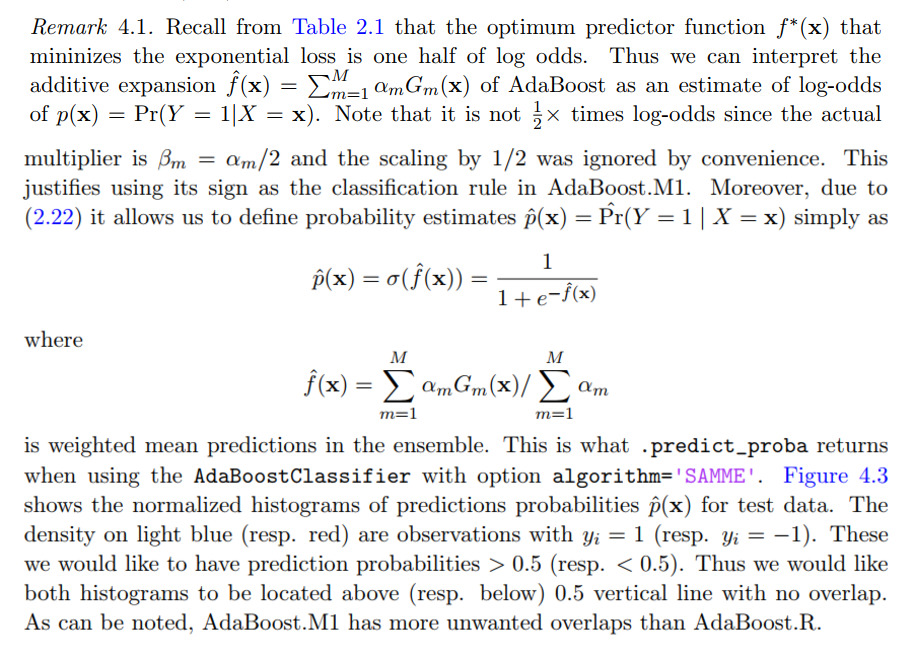

In [78]:
#### This is Remark 4.1 of lecture notes
Image("images/remark41.jpg")

In [102]:
def PredictProbaAdaBoostM1(G, alphas, X):
    # your code here
    sum_alphas = sum(alphas) 
    M = len(G)
    N = X.shape[0]
    #print(N)
    sum_fx = np.zeros(N)
    for i in range(M):
        ypred = G[i].predict(X)
        sum_fx += alphas[i] * ypred
    fx = sum_fx/sum_alphas
    Prob = 1/(1 + np.exp(-fx))
    return Prob

Prob = PredictProbaAdaBoostM1(G, alphas, X)
print(Prob)

[0.53077548 0.47998477 0.55141956 ... 0.51642967 0.56208886 0.53089967]


## (d)
Use the functions you made in a)-c) parts to redo Figure 4.1a and Figure 4.3a.  
When making histogram of probability predictions, you should use  <code>plt.hist( , **kwargs) </code> with following key word arguments:
    
<code>kwargs = dict(alpha=0.7, bins=50,density=True,stacked=True)</code>

In [54]:
M = 600 # use 600 boosting iterations
node = 2 # for stumps

#### Plot for test/training errors

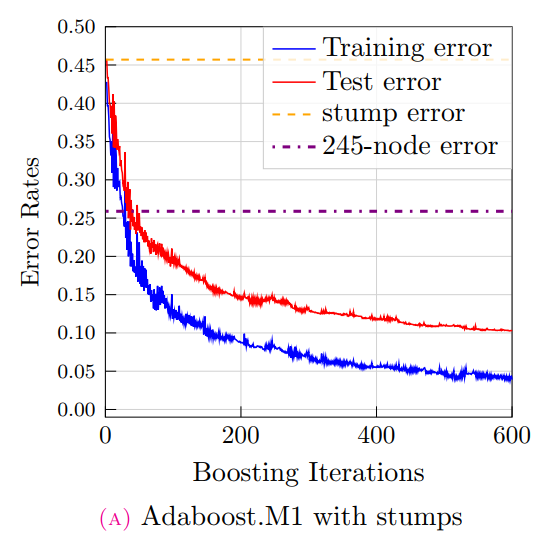

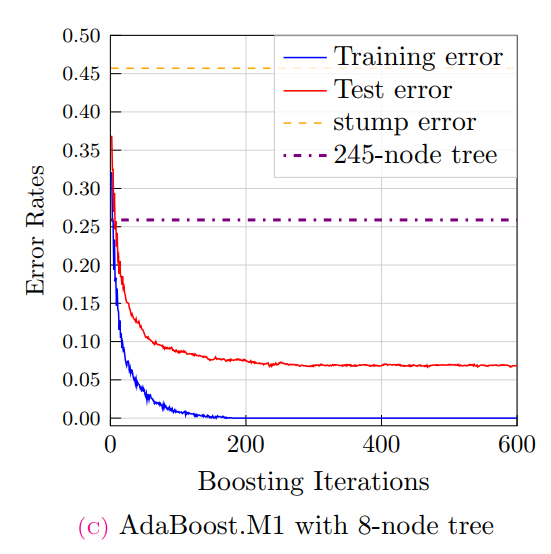

In [ ]:
#### This is Figure 4.1a and 4.1c referenced figure
x = Image(filename='images/adaboostm1_errors_stump.png') 
y = Image(filename='images/adaboostm1_errors_8nodes.png') 
display(x, y)

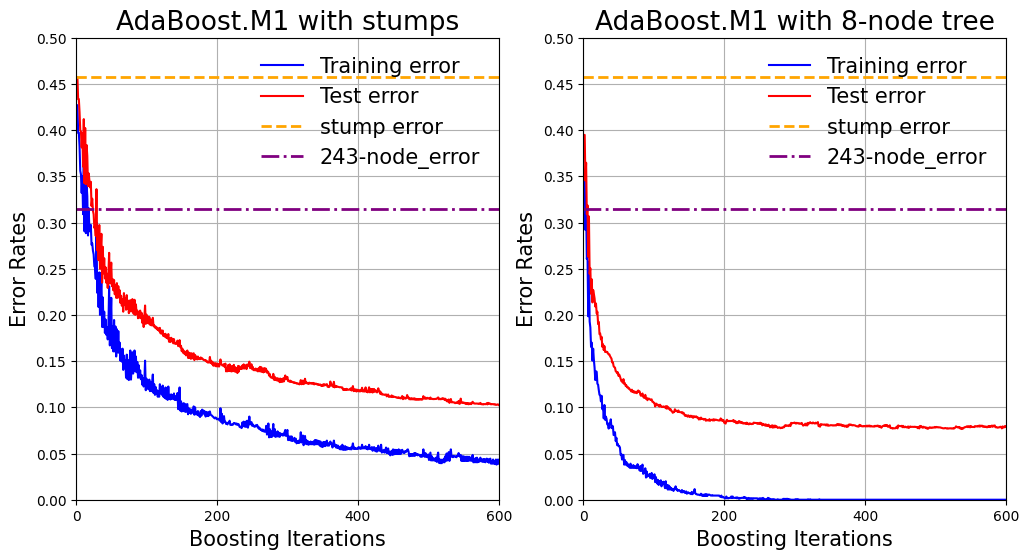

In [75]:
# your code here
size = 15
nodes = [2, 8]
flag = ["stumps", "8-node tree"]

numberOfIterations = range(1,M+1)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(2):
    G, alphas = MyAdaBoostM1(X, y, M, nodes[i])
    yhatTrain, trainingErrors = PredictAdaBoostM1(G, alphas, X, y)
    yhatTest, testingErrors = PredictAdaBoostM1(G, alphas, Xt, yt)
    axs[i].set_title(f"AdaBoost.M1 with {flag[i]}", size=size + 4)
    axs[i].plot(numberOfIterations, trainingErrors, label = "Training error", color="blue")
    axs[i].plot(numberOfIterations, testingErrors, label = "Test error", color="red")
    axs[i].axhline(y=stump_error, label = "stump error", color='orange', lw=2, linestyle="--")
    axs[i].axhline(y=tree_manynodes_error, label = f"{n_nodes}-node_error", color='purple', lw=2, linestyle="-.")
    axs[i].set_xticks([0, 200, 400, 600],fontsize=size)    
    axs[i].set_yticks(np.linspace(0.00, 0.50, num=11),fontsize=size)  
    axs[i].set_ylim([0, 0.5])
    axs[i].set_xlim([0, 600])
    axs[i].set_xlabel("Boosting Iterations", size=size)
    axs[i].set_ylabel("Error Rates", size=size)
    axs[i].legend(loc=1, frameon=False, fontsize=size)
    axs[i].grid()

#### plot of histograms

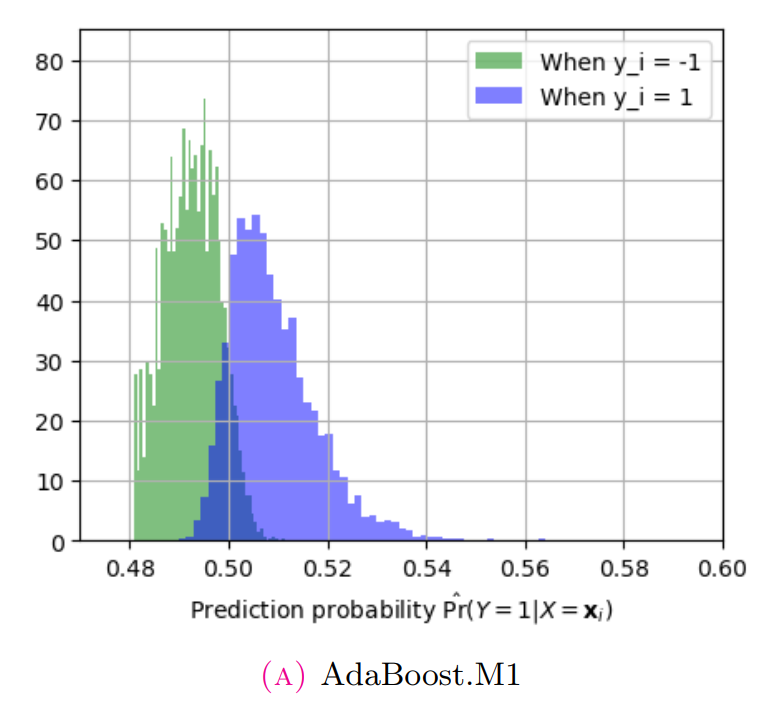

In [76]:
#### This is Figure 4.3a referenced figure
Image("images/adaboostm1_histogram.png")

In [126]:
def PredictProbaAdaBoostM1(G, alphas, X):
    # your code here
    sum_alphas = sum(alphas) 
    M = len(G)
    N = X.shape[0]
    sum_fx = np.zeros(N)
    for i in range(M):
        ypred = G[i].predict(X)
        sum_fx += alphas[i] * ypred
    fx = sum_fx/sum_alphas
    Prob = 1/(1 + np.exp(-fx))
    return Prob

Prob = PredictProbaAdaBoostM1(G, alphas, X)

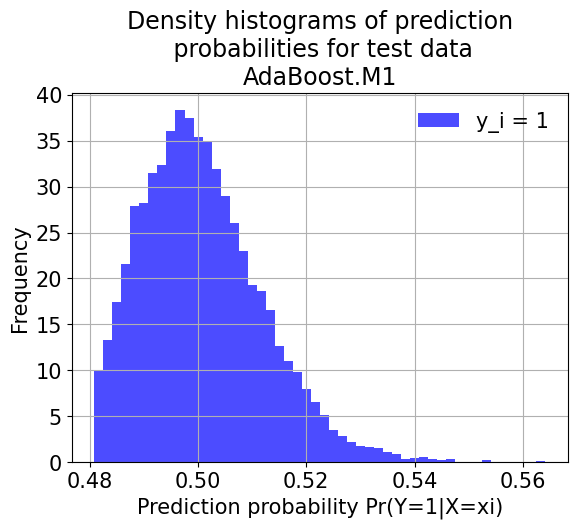

In [127]:
# Normalize
kwargs = dict(alpha=0.7, bins=50,density=True,stacked=True)
# your code here 
G, alphas = MyAdaBoostM1(X, y, M, 2)
Proby1 = PredictProbaAdaBoostM1(G, alphas, Xt)
Probyminus1 = 1 - Proby1
plt.title(f"Density histograms of prediction\n probabilities for test data\nAdaBoost.M1", size=size + 2)

plt.hist(Proby1, alpha=0.7, bins=50,density=True,stacked=True, label = "y_i = 1", color="blue")
#plt.hist(Probyminus1, alpha=0.7, bins=50,density=True,stacked=True, label = "y_i = -1", color="green")
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
#plt.ylim([0, 0.5])
#plt.xlim([0, 600])

plt.xlabel("Prediction probability Pr(Y=1|X=xi)", size=size)
plt.ylabel("Frequency", size=size)
plt.legend(loc=1, frameon=False, fontsize=size)
plt.grid()
